Based on https://bambinos.github.io/bambi/main/notebooks/ESCS_multiple_regression.html

# Multiple linear regression

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

az.style.use("arviz-darkgrid")
SEED = 7355608

# Load Data

In [2]:
data = bmb.load_data("ESCS")
np.round(data.describe(), 2)

,drugs,n,e,o,a,c,hones,emoti,extra,agree,consc,openn
count,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00,604.00
mean,2.21,80.04,106.52,113.87,124.63,124.23,3.89,3.18,3.21,3.13,3.57,3.41
std,0.65,23.21,19.88,21.12,16.67,18.69,0.45,0.46,0.53,0.47,0.44,0.52
min,1.00,23.00,42.00,51.00,63.00,44.00,2.56,1.47,1.62,1.59,2.00,1.28
25%,1.71,65.75,93.00,101.00,115.00,113.00,3.59,2.88,2.84,2.84,3.31,3.06
50%,2.14,76.00,107.00,112.00,126.00,125.00,3.88,3.19,3.22,3.16,3.56,3.44
75%,2.64,93.00,120.00,129.00,136.00,136.00,4.20,3.47,3.56,3.44,3.84,3.75
max,4.29,163.00,158.00,174.00,171.00,180.00,4.94,4.62,4.75,4.44,4.75,4.72


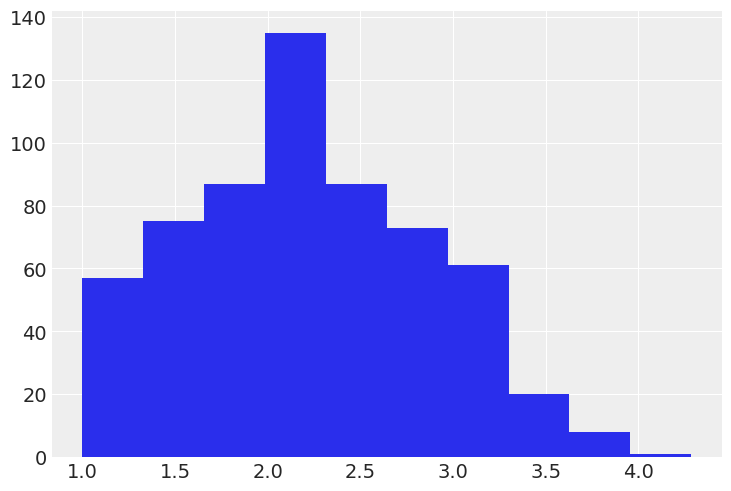

In [3]:
data["drugs"].hist();

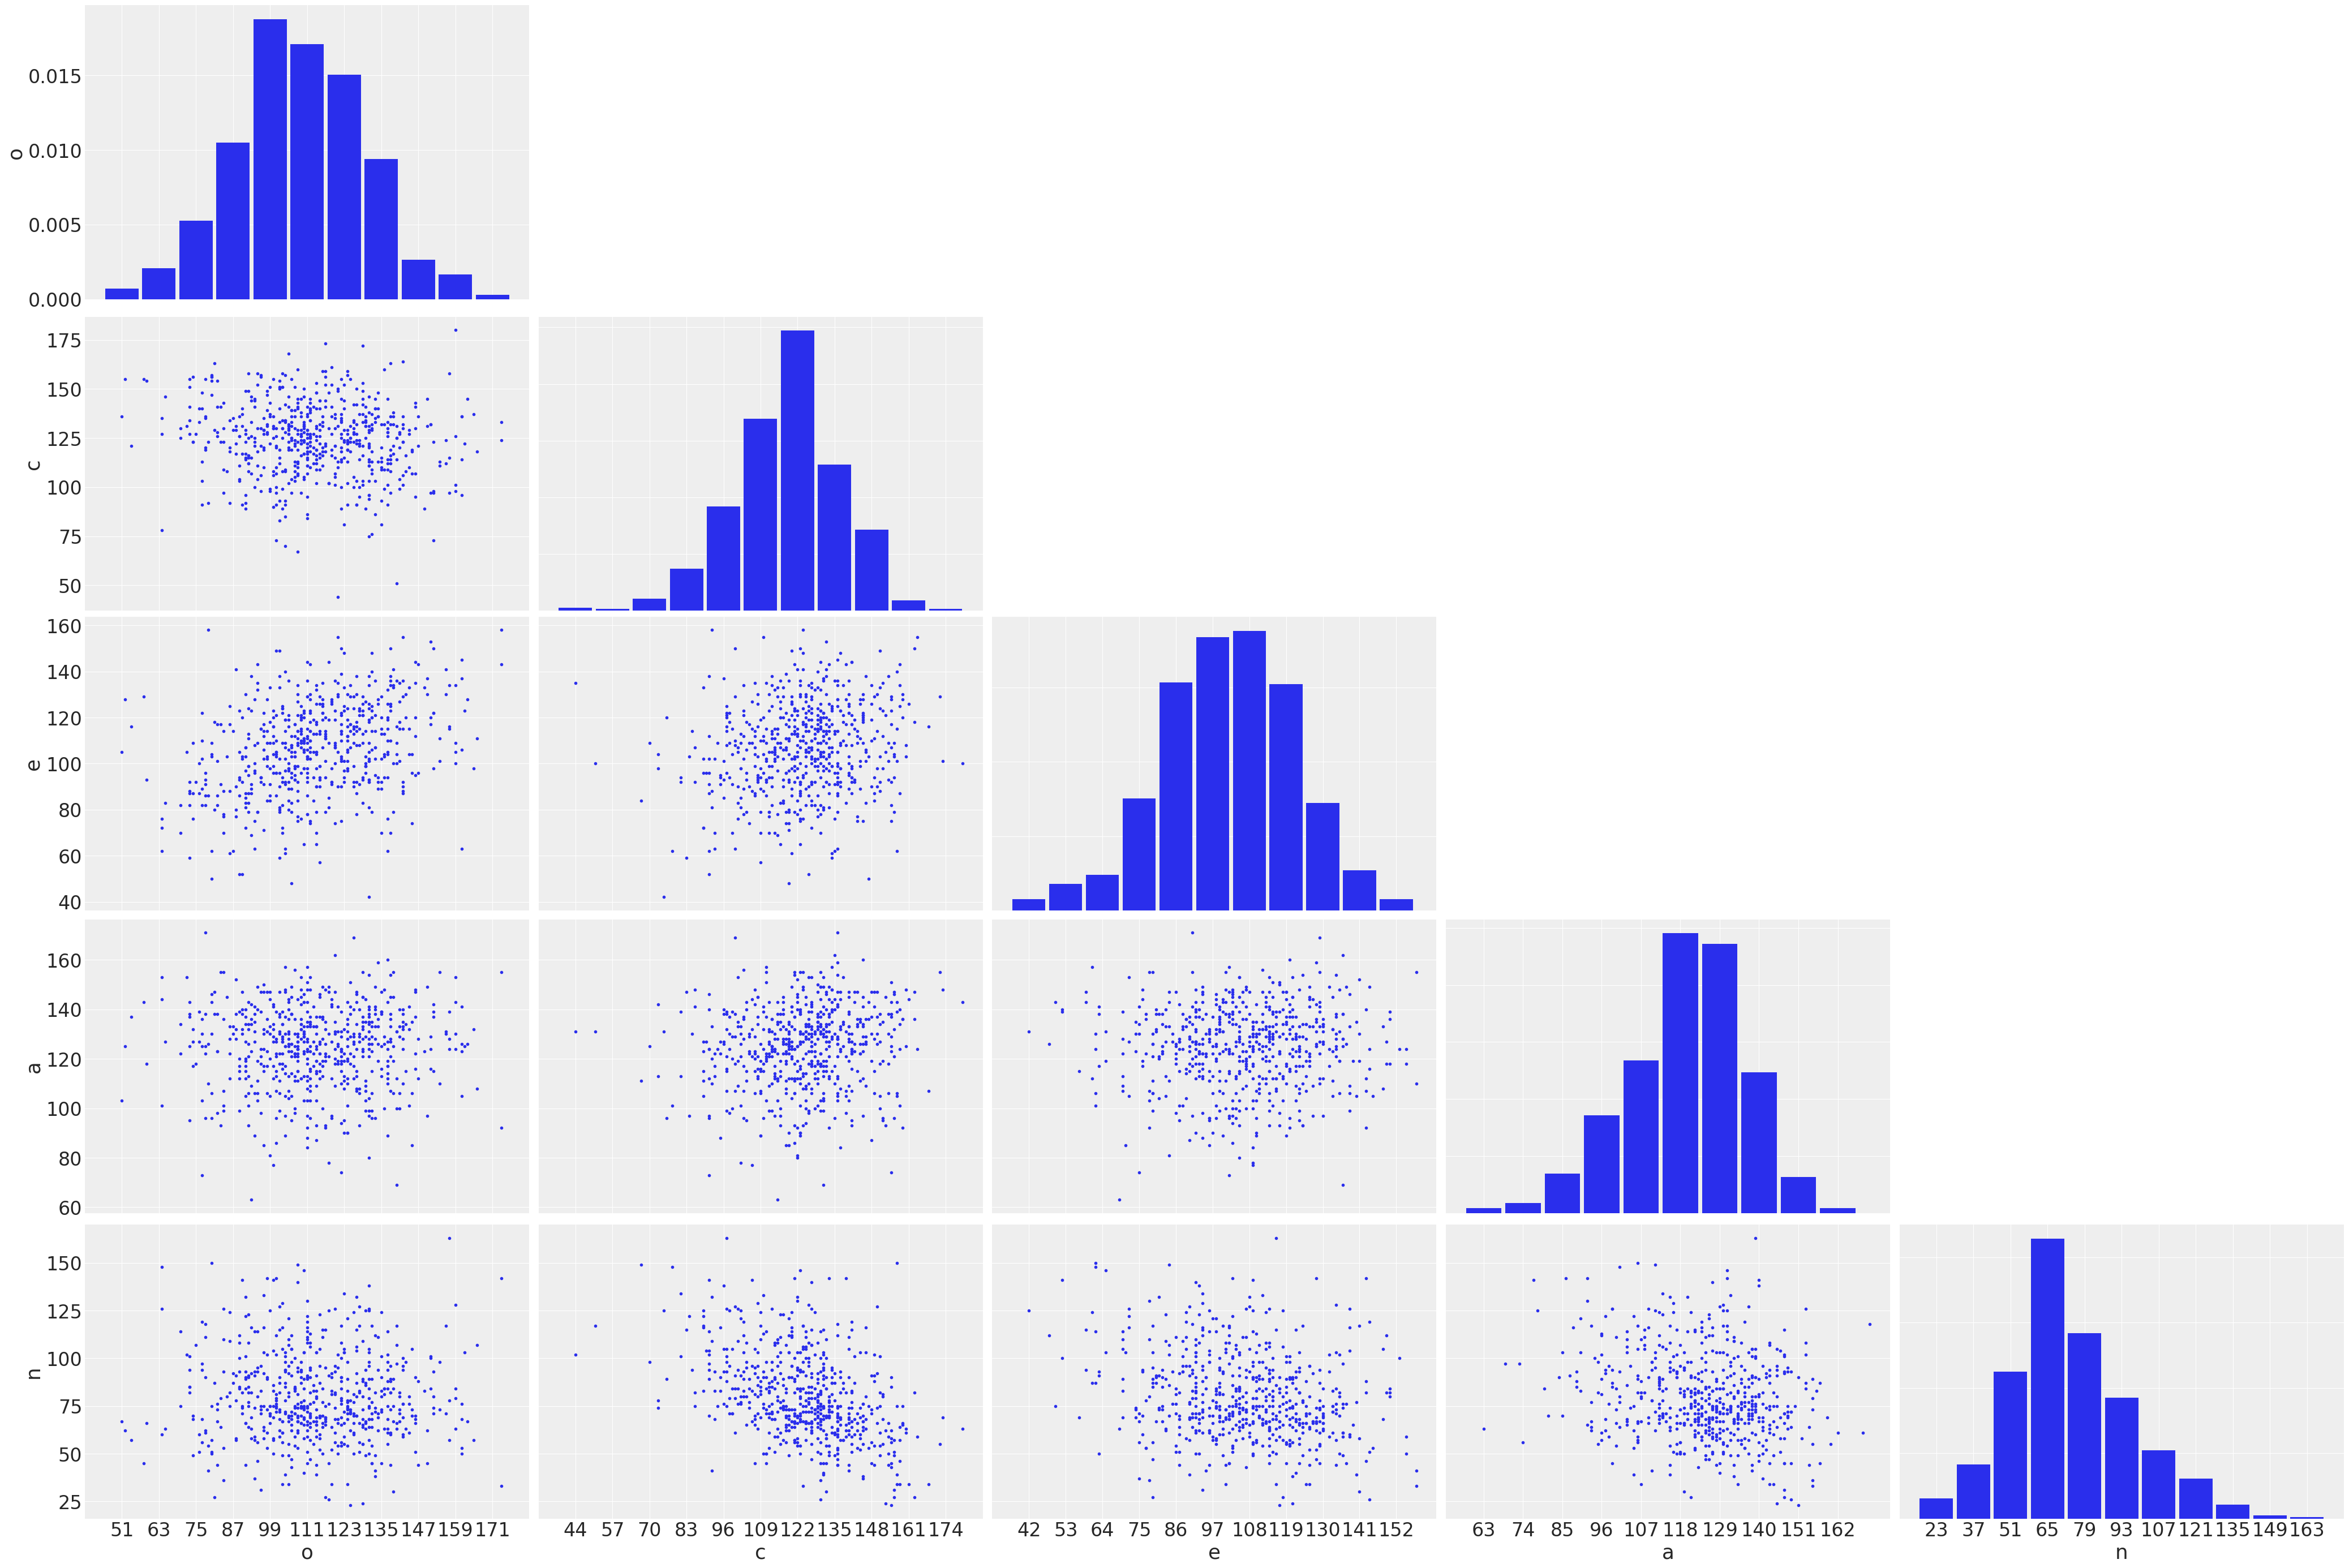

In [4]:
az.plot_pair(data[["o", "c", "e", "a", "n"]].to_dict("list"), marginals=True, textsize=24);

# Model

In [5]:
model = bmb.Model("drugs ~ o + c + e + a + n", data)
fitted = model.fit(tune=2000, draws=2000, init="adapt_diag", random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, o, c, e, a, n, drugs_sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


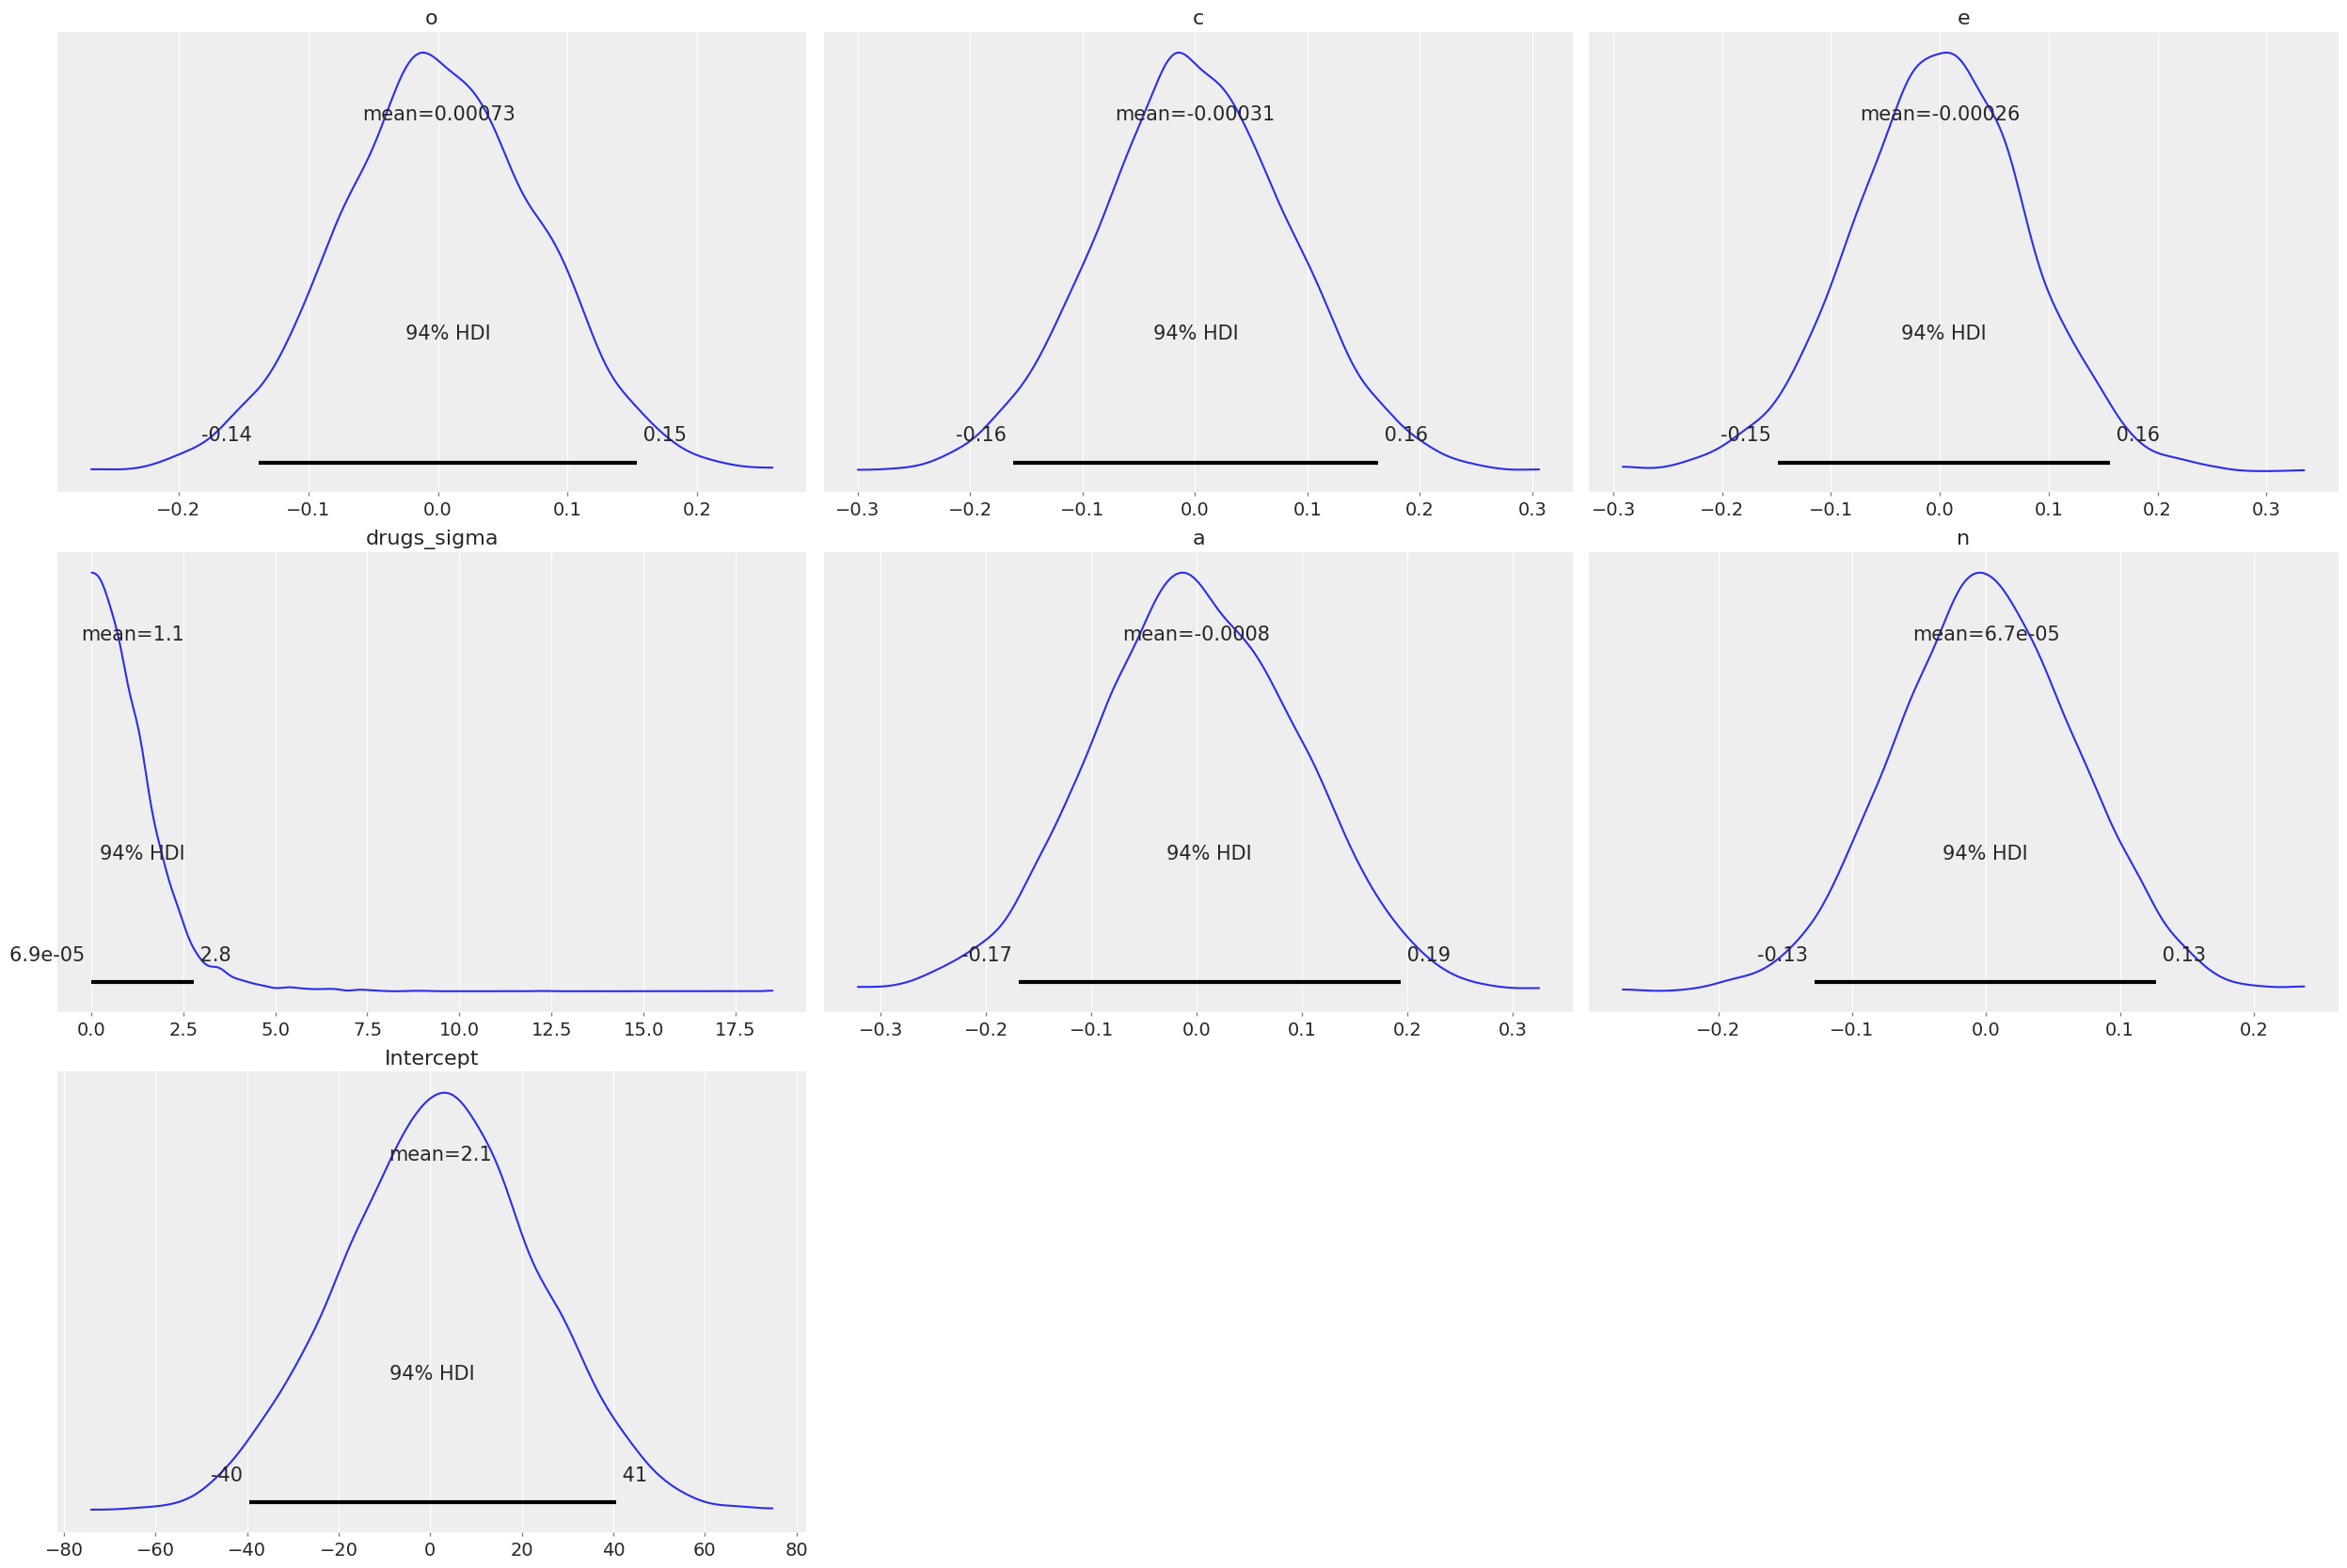

In [6]:
model.plot_priors();

In [7]:
# Normal priors on the coefficients
{x.name: x.prior.args for x in model.terms.values()}

{'Intercept': {'mu': array(2.21014664), 'sigma': array(21.19375074)},
 'o': {'mu': array(0.), 'sigma': array(0.0768135)},
 'c': {'mu': array(0.), 'sigma': array(0.08679683)},
 'e': {'mu': array(0.), 'sigma': array(0.0815892)},
 'a': {'mu': array(0.), 'sigma': array(0.09727366)},
 'n': {'mu': array(0.), 'sigma': array(0.06987412)}}

In [8]:
# HalfStudentT prior on the residual standard deviation
model.family.likelihood.priors

{'sigma': HalfStudentT(nu: 4, sigma: 0.6482)}

In [9]:
model

Formula: drugs ~ o + c + e + a + n
Family name: Gaussian
Link: identity
Observations: 604
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 2.2101, sigma: 21.1938)
    o ~ Normal(mu: 0.0, sigma: 0.0768)
    c ~ Normal(mu: 0.0, sigma: 0.0868)
    e ~ Normal(mu: 0.0, sigma: 0.0816)
    a ~ Normal(mu: 0.0, sigma: 0.0973)
    n ~ Normal(mu: 0.0, sigma: 0.0699)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 0.6482)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

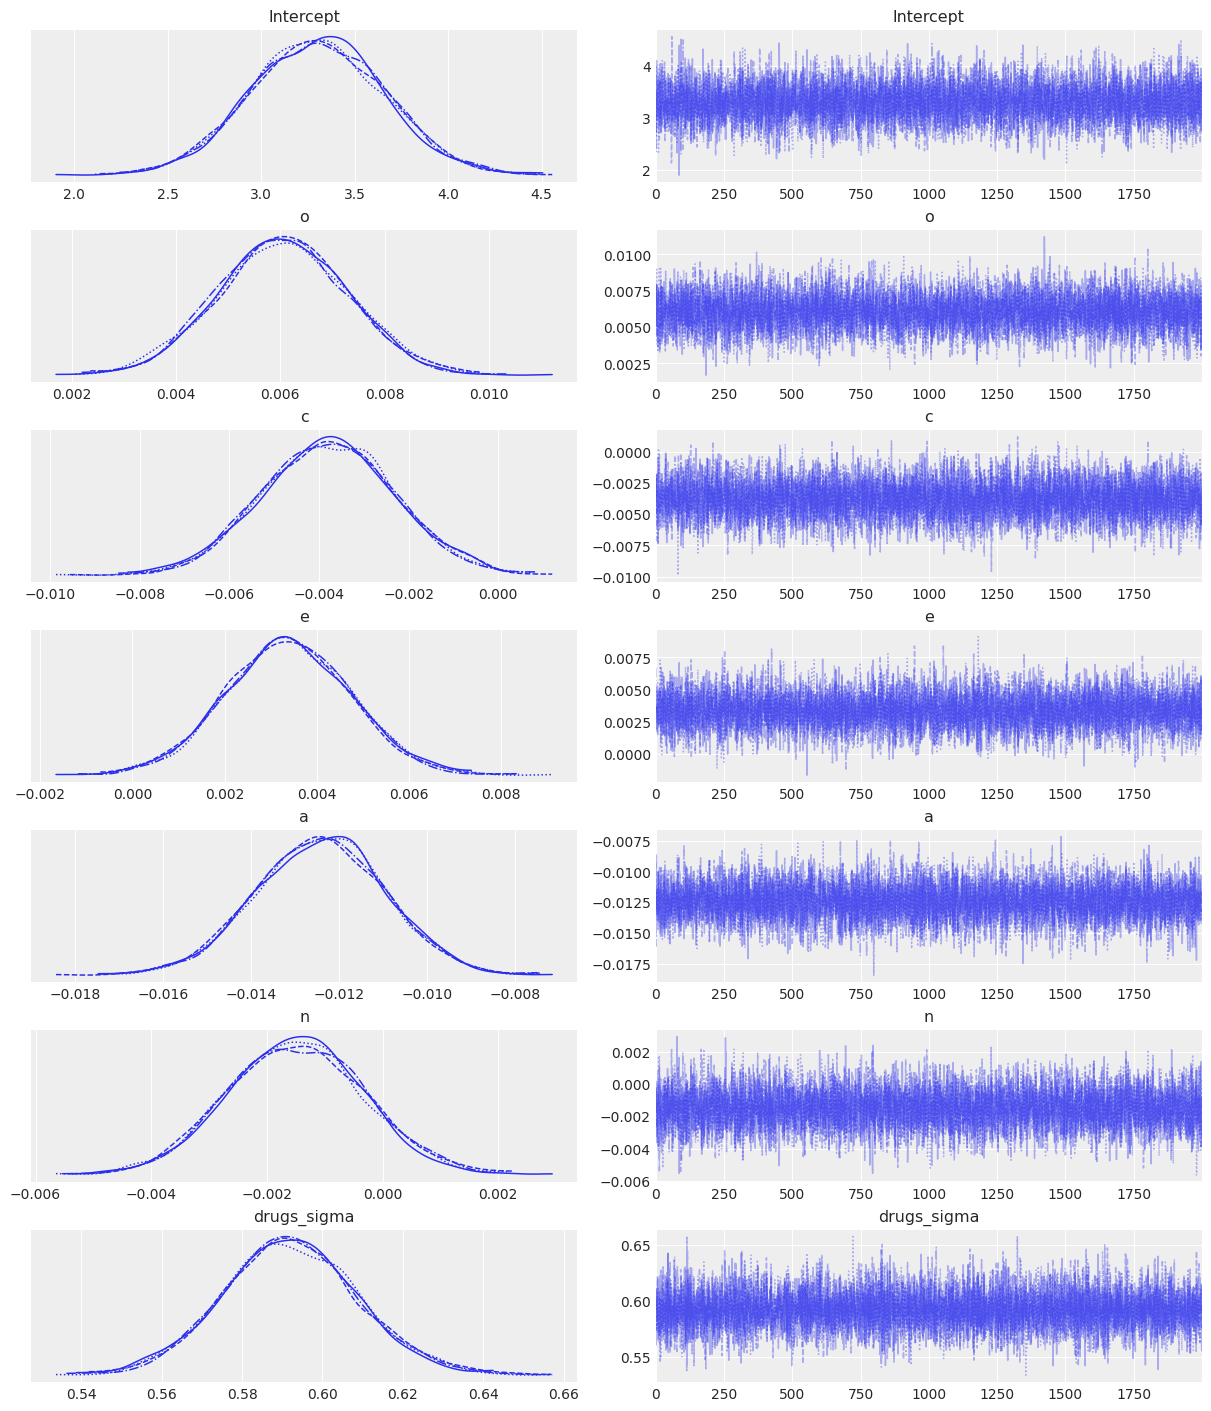

In [10]:
az.plot_trace(fitted);

In [11]:
az.summary(fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,3.300,0.355,2.654,3.985,0.004,0.003,7269.0,6519.0,1.0
o,0.006,0.001,0.004,0.008,0.000,0.000,7021.0,6198.0,1.0
c,-0.004,0.001,-0.007,-0.001,0.000,0.000,8624.0,6852.0,1.0
e,0.003,0.001,0.001,0.006,0.000,0.000,8077.0,6631.0,1.0
a,-0.012,0.001,-0.015,-0.010,0.000,0.000,9107.0,6660.0,1.0
n,-0.001,0.001,-0.004,0.001,0.000,0.000,7724.0,6286.0,1.0
drugs_sigma,0.592,0.017,0.561,0.624,0.000,0.000,11094.0,6546.0,1.0


# Summarize effects on partial correlation scale

In [12]:
samples = fitted.posterior

In [13]:
# the names of the predictors
varnames = ['o', 'c', 'e', 'a', 'n']

# compute the needed statistics like R-squared when each predictor is response and all the
# other predictors are the predictor

# x_matrix = common effects design matrix (excluding intercept/constant term)
terms = [t for t in model.common_terms.values() if t.name != "Intercept"]
x_matrix = [pd.DataFrame(x.data, columns=x.levels) for x in terms]
x_matrix = pd.concat(x_matrix, axis=1)

dm_statistics = {
    'r2_x': pd.Series(
        {
            x: sm.OLS(
                endog=x_matrix[x],
                exog=sm.add_constant(x_matrix.drop(x, axis=1))
                if "Intercept" in model.term_names
                else x_matrix.drop(x, axis=1),
            )
            .fit()
            .rsquared
            for x in list(x_matrix.columns)
        }
    ),
    'sigma_x': x_matrix.std(),
    'mean_x': x_matrix.mean(axis=0),
}

r2_x = dm_statistics['r2_x']
sd_x = dm_statistics['sigma_x']
r2_y = pd.Series([sm.OLS(endog=data['drugs'],
                         exog=sm.add_constant(data[[p for p in varnames if p != x]])).fit().rsquared
                  for x in varnames], index=varnames)
sd_y = data['drugs'].std()

# compute the products to multiply each slope with to produce the partial correlations
slope_constant = (sd_x[varnames] / sd_y) * ((1 - r2_x[varnames]) / (1 - r2_y)) ** 0.5
slope_constant

o    32.392557
c    27.674284
e    30.305117
a    26.113299
n    34.130431
dtype: float64

In [14]:
pcorr_samples = (samples[varnames] * slope_constant)

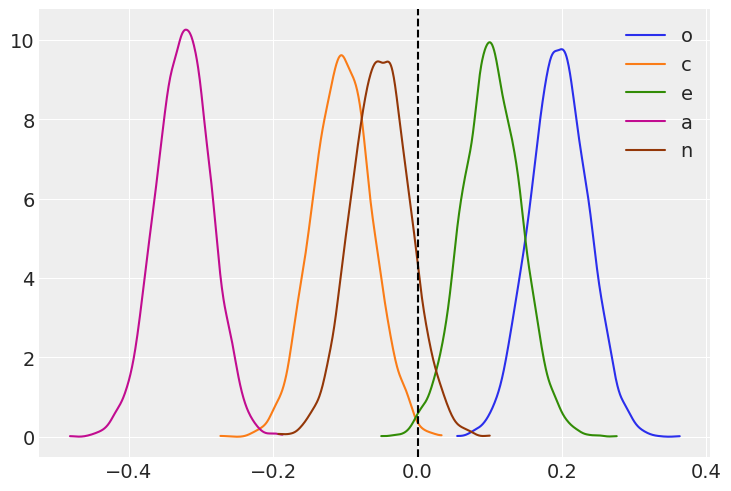

In [15]:
# Pass the same axes to az.plot_kde to have all the densities in the same plot
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.axvline(x=0, color='k', linestyle='--');

In [16]:
pcorr_samples.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    o        float64 0.1961
    c        float64 -0.1047
    e        float64 0.1023
    a        float64 -0.3246
    n        float64 -0.05108

# Relative importance

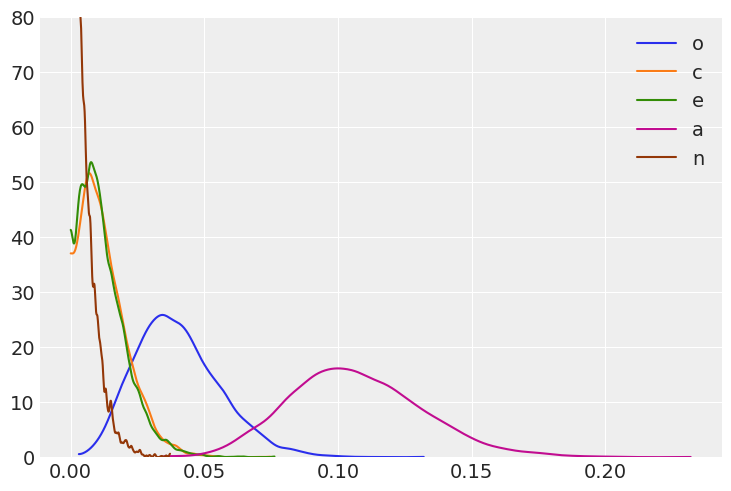

In [18]:
_, ax = plt.subplots()
for idx, (k, v) in enumerate(pcorr_samples.items()):
    az.plot_dist(v ** 2, label=k, plot_kwargs={'color':f'C{idx}'}, ax=ax)
ax.set_ylim(0, 80);

In [19]:
(pcorr_samples['o'] ** 2 > pcorr_samples['c'] ** 2).mean().item()

0.92675

In [20]:
sq_partial_c = pcorr_samples['c'] ** 2
sq_partial_o = pcorr_samples['o'] ** 2

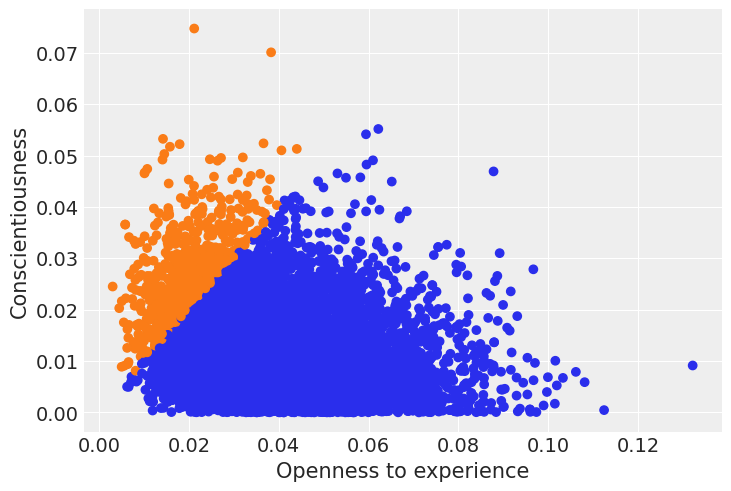

In [21]:
colors = np.where(sq_partial_c > sq_partial_o, "C1", "C0").flatten().tolist()

plt.scatter(sq_partial_o, sq_partial_c, c=colors)
plt.xlabel("Openness to experience")
plt.ylabel("Conscientiousness");

In [22]:
xr.corr(sq_partial_c, sq_partial_o).item()

-0.1991972901345141

# Posterior Predictive

In [23]:
posterior_predictive = model.predict(fitted, kind="pps")
fitted

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

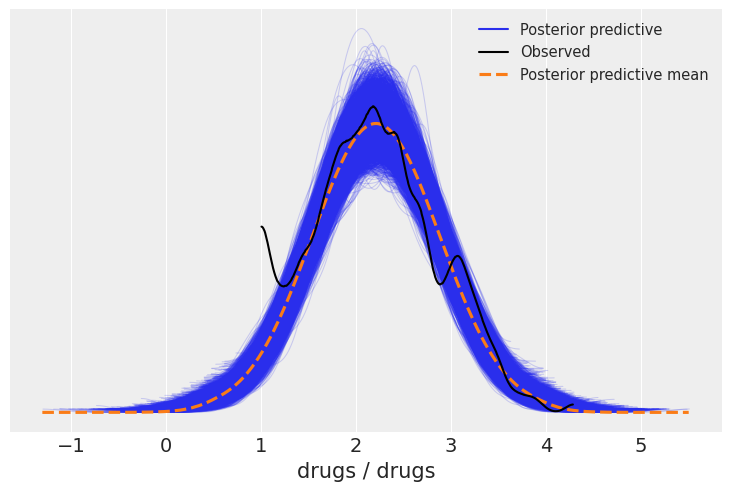

In [24]:
az.plot_ppc(fitted);

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 19 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

matplotlib : 3.5.3
numpy      : 1.21.6
pandas     : 1.4.3
statsmodels: 0.13.2
arviz      : 0.12.1
xarray     : 2022.6.0
bambi      : 0.9.0

Watermark: 2.3.1

